In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Link to source code

https://github.com/juliafairbank7/juliafairbank7.github.io/blob/main/posts/

# Downloading the Data

We will be using data from the American Community Survey’s Public Use Microdata Sample (PUMS). Let's start by downloading a complete set of PUMS data for the state of Montana.

In [24]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "MT"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000197,8,1,300,4,30,1013097,41,61,...,67,40,42,42,37,40,6,6,6,94
1,P,2018GQ0001300,8,1,700,4,30,1013097,47,57,...,43,81,87,91,44,8,43,82,42,110
2,P,2018GQ0001512,8,1,500,4,30,1013097,114,18,...,103,17,104,117,219,182,17,17,200,232
3,P,2018GQ0001743,8,1,300,4,30,1013097,76,28,...,66,75,71,76,79,132,140,143,70,11
4,P,2018GQ0002532,8,1,300,4,30,1013097,112,18,...,16,198,101,211,113,95,111,213,195,19


As you can see, this pulls up a ton of data. Let's try to parse out a small number of features before we start analyzing. 

In [25]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,61,16.0,3,16,2,NaN,1,1.0,4.0,1,1,2,2,2.0,1,1,6.0
1,57,17.0,3,16,1,NaN,1,3.0,4.0,1,1,2,2,1.0,1,1,6.0
2,18,19.0,5,17,2,NaN,1,3.0,4.0,2,1,2,2,2.0,2,1,6.0
3,28,14.0,3,16,1,NaN,1,1.0,2.0,1,1,2,2,1.0,1,1,6.0
4,18,16.0,5,17,1,NaN,1,3.0,4.0,2,1,2,1,2.0,2,9,6.0


We have now pulled out a few features including age (AGEP), education attainment (SCHL), marital status (MAR), relationship (RELP), disability recode (DIS), race (RAC1P), sex (SEX) and more.

Let's now create a subset for the features we want to use, then construct a BasicProblem to use those features to predict employment status (ESR), using race (RAC1P) as the group label.

In [26]:
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

EmploymentProblem returns a feature matrix (features), a label vector label, and a group label vector group. 

Next, we will perform a train-test split, then get into creating our model!

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

We can extract predictions on a test set by calling:

In [29]:
y_hat = model.predict(X_test)

By taking the mean, we can get the overall accuracy in predicting one's employment by calling:

In [30]:
(y_hat == y_test).mean()

0.7514506769825918

We can also group by race (RAC1P) to determine the accuracy for different groups. Below, we can extract the accuracy for predicting the employment of white individuals....

In [31]:
(y_hat == y_test)[group_test == 1].mean() #white individuals

0.7554704595185996

... compared to the accuracy for predicting the employment of black individuals....

In [32]:
(y_hat == y_test)[group_test == 2].mean() #black individuals

0.875

Now that we've seen what this model can do, I will be predicting employment status on the basis of demographics excluding race, and then auditing for racial bias.

In [33]:
import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use)
df["RACE"] = group_train
df["ESR_label"] = y_train
df

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RACE,ESR_label
0,87.0,21.0,1.0,16.0,1.0,0.0,1.0,1.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,1,False
1,79.0,16.0,1.0,0.0,2.0,0.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1,True
2,27.0,20.0,5.0,0.0,2.0,0.0,1.0,3.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,1,True
3,94.0,16.0,2.0,0.0,1.0,0.0,1.0,1.0,4.0,4.0,1.0,1.0,2.0,2.0,2.0,1,False
4,40.0,20.0,5.0,15.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8263,25.0,22.0,5.0,12.0,2.0,0.0,1.0,1.0,4.0,4.0,1.0,2.0,2.0,2.0,2.0,1,True
8264,10.0,6.0,5.0,2.0,2.0,1.0,3.0,1.0,0.0,1.0,1.0,2.0,2.0,2.0,1.0,1,False
8265,29.0,21.0,1.0,0.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,1,True
8266,78.0,17.0,1.0,1.0,2.0,0.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1,False


# Analyzing the Data

## 1. How many individuals are in the dataframe?

In [34]:
total = len(df.index)
total

8268

There are 8,268 individuals in this dataset. 

## 2. What proportion have a target label equal to 1?

In [37]:
total_ = len(df[df['ESR_label'] == 1])
proportion_ = total_ / total
proportion_

0.45379777455249154

Of those individuals, the proportion of people that have a target label equal to 1 (employed individuals) is 45.3798%.

## 3. Of these individuals, how many are in each of the groups?

In [40]:
label1 = df[df['ESR_label'] == 1]
label1_groups = label1.groupby(['RACE'])['RACE'].count()
print(label1_groups)

RACE
1    3460
2       8
3     166
5       5
6      21
7       2
8      13
9      77
Name: RACE, dtype: int64


See the values above to see how many individuals that have a target label = 1 are in each of the groups. 

For reference,
- Race 1: White alone
- Race 2 Black or African American alone
- Race 3: American Indian alone
- Race 4: Alaska Native alone
- Race 5: American Indian and Alaska Native tribes specified, or American Indian or Alaska
Native, not specified and no other races
- Race 6: Asian alone
- Race 7: Native Hawaiian and Other Pacific Islander alone
- Race 8: Some Other Race alone
- Race 9: Two or More Races

## 4. In each group, what proportion of individuals have target label equal to 1?

In [42]:
label1_groups_ratio = df.groupby(['RACE'])['ESR_label'].mean()
print(label1_groups_ratio)

RACE
1    0.471005
2    0.470588
3    0.286701
4    0.000000
5    0.200000
6    0.500000
7    0.500000
8    0.333333
9    0.358140
Name: ESR_label, dtype: float64


##  5. Check for intersectional trends by studying the proportion of positive target labels broken out by your chosen group labels and an additional group label. 

In [47]:
label1_groups_sex = df.groupby(['RACE', 'SEX'])['ESR_label'].mean()
print(label1_groups_sex)

RACE  SEX
1     1.0    0.489674
      2.0    0.452264
2     1.0    0.583333
      2.0    0.200000
3     1.0    0.265683
      2.0    0.305195
4     2.0    0.000000
5     1.0    0.166667
      2.0    0.230769
6     1.0    0.500000
      2.0    0.500000
7     1.0    0.500000
      2.0    0.500000
8     1.0    0.250000
      2.0    0.421053
9     1.0    0.357143
      2.0    0.359551
Name: ESR_label, dtype: float64


[Text(0.5, 0, 'Race'), Text(0, 0.5, 'Education Status Recode')]

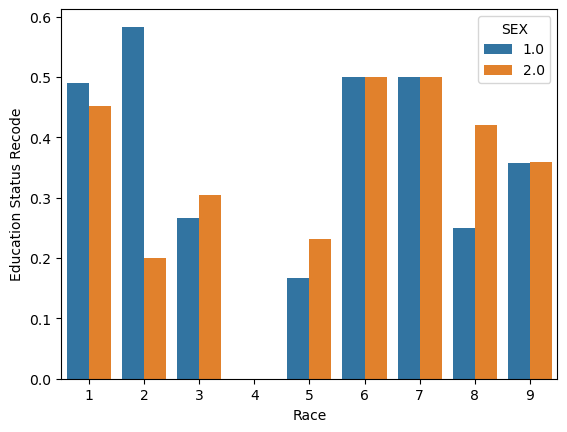

In [58]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

result = label1_groups_sex.to_frame().reset_index()
figure = sns.barplot(x='RACE', y = 'ESR_label', hue = 'SEX', data = result)
figure.set(xlabel="Race", ylabel="Education Status Recode")

## Training the Model

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

## Auditing the Model

### Overall Measures

1. What is the overall accuracy of your model?

In [72]:
y_hat = model.predict(X_test)
(y_hat == y_test).mean()

0.7514506769825918

The overall accuracy is 75.15%. 

2. What is the positive predictive value (PPV) of your model?

In [82]:
df_audit = pd.DataFrame(X_test, columns = features_to_use)

df_audit["RACE"] = group_test
df_audit["ESR_label"] = y_test
df_audit["predicted"] = y_hat
df_audit["match"] = (df_audit["predicted"] == y_test)
df_audit

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RACE,ESR_label,predicted,match
0,49.0,19.0,5.0,0.0,2.0,0.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1,True,False,False
1,56.0,16.0,3.0,0.0,2.0,0.0,1.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,1,False,True,False
2,11.0,8.0,5.0,2.0,2.0,1.0,1.0,1.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,1,False,False,True
3,8.0,4.0,5.0,2.0,1.0,2.0,1.0,1.0,0.0,2.0,1.0,2.0,2.0,1.0,1.0,1,False,False,True
4,18.0,1.0,5.0,17.0,2.0,0.0,1.0,1.0,3.0,1.0,1.0,2.0,2.0,2.0,1.0,1,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,18.0,16.0,5.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0,1,True,True,True
2064,55.0,16.0,3.0,0.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,1,False,True,False
2065,85.0,12.0,1.0,16.0,1.0,0.0,3.0,1.0,4.0,2.0,1.0,2.0,2.0,1.0,1.0,1,False,False,True
2066,64.0,21.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,2.0,3,False,True,False


In [85]:
cm = confusion_matrix(df_audit["ESR_label"], df_audit["predicted"])
PPV = cm[1,1]/np.sum(cm[:,1])
print(PPV)

0.7122232916265641


3. What are the overall false negative and false positive rates (FNR and FPR) for your model?

In [91]:
TP = cm[1,1] ## true positive
FP = cm[0,1] ## false positive
TN = cm[0,0] ## true negative
FN = cm[1,0] ## false negative 

FNR = FN / (FN + TP)
FPR = FP / (FP + TN)

print("False Positive Rate:", FPR)
print("False Negative Rate:", FNR)

False Positive Rate: 0.26864330637915546
False Negative Rate: 0.225130890052356


### By-Group Measures

1. What is the accuracy of your model on each subgroup?

In [127]:
accuracy_sGroup = df_audit.groupby(['RACE'])['match'].mean()
print(accuracy_sGroup)
print(" ")
print("Accuracy for white individuals:", (y_hat == y_test)[group_test == 1].mean())
print("Accuracy for black individuals:", (y_hat == y_test)[group_test == 2].mean())

RACE
1    0.755470
2    0.875000
3    0.677632
4    1.000000
5    1.000000
6    0.500000
8    0.727273
9    0.823529
Name: match, dtype: float64
 
Accuracy for white individuals: 0.7554704595185996
Accuracy for black individuals: 0.875


2. What is the PPV of your model on each subgroup?

In [120]:
print("Positive Predicitive Value for White Individuals:", (np.sum(y_test[group_test == 1]) / np.sum(y_hat[group_test == 1])))
print("Positive Predicitive Value for Black Individuals:", (np.sum(y_test[group_test == 2]) / np.sum(y_hat[group_test == 2])))

Positive Predicitive Value for White Individuals: 0.9332627118644068
Positive Predicitive Value for Black Individuals: 1.3333333333333333


In [131]:
# RACE = 1, white individuals subgroup

cm_W = confusion_matrix(y_test[group_test == 1], y_hat[group_test == 1])

TP = cm_W[1,1] ## true positive
FP = cm_W[0,1] ## false positive
TN = cm_W[0,0] ## true negative
FN = cm_W[1,0] ## false negative 

FNR = FN / (FN + TP)
FPR = FP / (FP + TN)
PPV = TP / (TP + FP)

print("PPV for White Individuals:", PPV)
print("False Positive Rate for White Individuals:", FPR)
print("False Negative Rate for White Individuals:", FNR)

# RACE = 2, black individuals subgroup

cm_b = confusion_matrix(y_test[group_test == 2], y_hat[group_test == 2])

TP = cm_b[1,1] ## true positive
FP = cm_b[0,1] ## false positive
TN = cm_b[0,0] ## true negative
FN = cm_b[1,0] ## false negative 

FNR = FN / (FN + TP)
FPR = FP / (FP + TN)
PPV = TP / (TP + FP)
print(" ")
print("PPV for Black Individuals:", PPV)
print("False Positive Rate for Black Individuals:", FPR)
print("False Negative Rate for Black Individuals:", FNR)

PPV for White Individuals: 0.7298728813559322
False Positive Rate for White Individuals: 0.2692713833157339
False Negative Rate for White Individuals: 0.21793416572077184
 
PPV for Black Individuals: 1.0
False Positive Rate for Black Individuals: 0.0
False Negative Rate for Black Individuals: 0.25


### Bias Measures

1. Is your model approximately calibrated?

Of our subgroups, the PPV for white individuals is around 0.73 and the PPV for white individuals is 1.0. Therefore, I would say that the model is approximately calibrated, despite the PPV for white individuals not being perfectly calibrated. 

2. Does your model satisfy approximate error rate balance?

My model does not satisfy approximate error rate balance because the FPR and FNR are not equal across groups.
For white individuals, the FPR and FNR are close, 0.269 and 0.217 respectively, however for black individuals, the FPR and FNR are very different, being 0.0 and 0.25 respectively. Therefore, my model does not satisfy approximate error rate balance.

3. Does your model satisfy statistical parity?

In [134]:
positive_subgroups = df_audit.groupby(['RACE'])['predicted'].mean()
print(positive_subgroups)

RACE
1    0.516411
2    0.375000
3    0.407895
4    0.000000
5    0.142857
6    0.400000
8    0.545455
9    0.372549
Name: predicted, dtype: float64


To check whether my model satisfies statistical parity, we can look at the proportion of individuals classified as employed, and check whether that proportion is the same across groups. As you can see, the majority of the values seem to be in a range of 0.37 to 0.54, however there are a few outliers (0.00 for race 4 and 0.143 for race 5.) Because of these outliers and a wider range, I would say that my model does not satisfy statistical parity.

# Concluding Discussion

My model predicts employement status based on an individuals key demographics. This algorithm could be used in a variety of industries and companies, such as assisting with people taking out loans, renting/leasing homes, insurance policies, etc. However, because this model was trained on features that are affected by implicit, systematic bias, this model has the potential of perpetuating this bias and affecting individuals in serious matters, such as the examples I listed above. Because this model can have a lower accuracy or lower false positive/negative rates for certain races, use of this model and algorithm could lead to further discrimination. If this model was deployed on a larger scale in either a commerical or governmental settings, certain subgroups would disproportionately feel the negative impacts of using such an algorithm. 

Based on my bias audit, I was interested to find that my model outputed a perfect PPV for black individuals, and around 0.73 for white individiuals. I think its important to note again though, that this model is trained on biased data, so although my model had an impressive PPV for black individuals, this does not mean that my model is not biased. 

Overall, my model was only able to achieve an overall accuracy of 75.15%. I would argue that an algorithm that is only accurate around 70% is not reliable enough to be used in any sort of impactful manner. 